## Benchmark: ClickHouse Vs. InfluxDB Vs. Postgresql Vs. Parquet 

-----

#### How to use:
* Rename the file "properties-model.ini" to "properties.ini"
* Fill with your own credentials
----

The proposal of this work is to compare the speed in read/writing a midle level of data ( a dataset with 9 columns and 50.000 lines) to four diferent databases:
* ClickHouse
* InfluxDB
* Postgresql
* Parquet (in a S3 Minio Storage) <br>
ToDo: <br>
* DuckDB with Polars
* MongoDB
* Kdb+

 
Deve-se relevar:
é uma "cold-storage" ou  "frezze-storage"? <br>
influxdb: alta leitura e possui  a vantagem da indexaçõa para vizualização de dados em gráficos.

notas: 
* comparar tamanho do csv com parquet

### Imports 

In [170]:
import configparser
import io
import timeit
from datetime import datetime

import duckdb

# from influxdb_client import InfluxDBClient
import influxdb_client
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pdmongo as pdm
from clickhouse_driver import Client
from dotenv import load_dotenv

# from influxdb_client.client.write_api import SYNCHRONOUS
from minio import Minio
from pymongo import MongoClient
from pytz import timezone
from qbstyles import mpl_style
from qpython import qconnection
from sqlalchemy import create_engine

load_dotenv()

False

In [89]:
# Variables
dbname = "EURUSDtest"
collection = "finance"

In [50]:
arq = configparser.RawConfigParser()
arq.read("properties.ini")
ClickHouseUser = arq.get("CLICKHOUSE", "user")
ClickHouseKey = arq.get("CLICKHOUSE", "key")
ClickHouseUrl = arq.get("CLICKHOUSE", "url")

InfluxDBUser = arq.get("INFLUXDB", "user")
InfluxDBKey = arq.get("INFLUXDB", "key")
InfluxDBUrl = arq.get("INFLUXDB", "url")
InfluxDBBucket = arq.get("INFLUXDB", "bucket")

PostgresqlUser = arq.get("POSTGRESQL", "user")
PostgresqlKey = arq.get("POSTGRESQL", "key")
PostgresqlUrl = arq.get("POSTGRESQL", "url")
PostgresqlDB = arq.get("POSTGRESQL", "database")

S3MinioUser = arq.get("S3MINIO", "user")
S3MinioKey = arq.get("S3MINIO", "key")
S3MinioUrl = arq.get("S3MINIO", "url")
S3MinioRegion = arq.get("S3MINIO", "region")

MongoUser = arq.get("MONGODB", "user")
MongoKey = arq.get("MONGODB", "key")
MongoUrl = arq.get("MONGODB", "url")

In [51]:
# %%time
# Load Dataset
df = pd.read_csv("out.csv", index_col=0)
df.tail()

,id,from,at,to,open,close,min,max,volume
999995,7984748,2023-03-03 18:13:30,1677867225000000000,2023-03-03 18:13:45,1.062695,1.062635,1.062630,1.062700,64
999996,7984749,2023-03-03 18:13:45,1677867240000000000,2023-03-03 18:14:00,1.062645,1.062650,1.062625,1.062650,43
999997,7984750,2023-03-03 18:14:00,1677867255000000000,2023-03-03 18:14:15,1.062640,1.062625,1.062620,1.062665,47
999998,7984751,2023-03-03 18:14:15,1677867270000000000,2023-03-03 18:14:30,1.062625,1.062535,1.062535,1.062645,43
999999,7984752,2023-03-03 18:14:30,1677867285000000000,2023-03-03 18:14:45,1.062535,1.062520,1.062520,1.062580,59


In [ ]:
df["from"] = pd.to_datetime(df["from"], unit="s")
df["to"] = pd.to_datetime(df["to"], unit="s")
# Optional use when not transoformed yet
# Transform Datetime

#### Funçoes

-> Class

In [5]:
def timestamp2dataHora(x, timezone_="America/Sao_Paulo"):
    d = datetime.fromtimestamp(x, tz=timezone(timezone_))
    return d

### ClickHouse

In [62]:
# !! driver tcp.
def cHouseConnect():
    client = Client(
        host=ClickHouseUrl,
        user=ClickHouseUser,
        password=ClickHouseKey,
        settings={"use_numpy": True},
    )
    return client


def cHouseDropTables(databasename):
    client = cHouseConnect()
    client.execute("DROP TABLE {}".format(databasename))
    client.disconnect()
    return "Database deleted"


# Create Tables in ClickHouse
# !! ALTERAR TIPOS !!
# ENGINE: 'Memory' desaparece quando server é reiniciado
def cHouseCreateDb(databasename):
    client = cHouseConnect()
    client.execute(
        "CREATE TABLE IF NOT EXISTS {} (id UInt32,"
        "from DateTime, at UInt64, to DateTime, open Float64,"
        "close Float64, min Float64, max  Float64, volume UInt32)"
        "ENGINE MergeTree ORDER BY to".format(databasename)
    )
    client.disconnect()
    return "Database created"


# Write dataframe to db
def cHouseInsertDf(dbName, dataframe):
    client = cHouseConnect()
    client.insert_dataframe("INSERT INTO {} VALUES".format(dbName), dataframe)
    client.disconnect()
    return " dataframe {} inserted in clickhouse database".format(dataframe)


def cHouseQueryDf(databaseName):
    client = cHouseConnect()
    dfQuery = client.query_dataframe("SELECT * FROM default.{}".format(databaseName))
    client.disconnect()
    return dfQuery


cHouseCreateDb(dbname)

'Database created'

In [63]:
# Insert to db and benchmark time
start = timeit.default_timer()
cHouseInsertDf(dbname, df)
stop = timeit.default_timer()
cHouse_write_execution_time = stop - start

In [64]:
# read from db and benchmark time
start = timeit.default_timer()
dfCh = cHouseQueryDf(dbname)
stop = timeit.default_timer()
cHouse_read_execution_time = stop - start

In [57]:
dfCh.tail()

,id,from,at,to,open,close,min,max,volume
1999995,8083054,2023-03-28 18:54:00,1680029655003247667,2023-03-28 18:54:15,1.084015,1.084015,1.083995,1.084040,42
1999996,8083055,2023-03-28 18:54:15,1680029670000000000,2023-03-28 18:54:30,1.084020,1.083950,1.083940,1.084045,55
1999997,8083055,2023-03-28 18:54:15,1680029670000000000,2023-03-28 18:54:30,1.084020,1.083950,1.083940,1.084045,55
1999998,8083056,2023-03-28 18:54:30,1680029685000000000,2023-03-28 18:54:45,1.083965,1.083955,1.083945,1.083975,40
1999999,8083056,2023-03-28 18:54:30,1680029685000000000,2023-03-28 18:54:45,1.083965,1.083955,1.083945,1.083975,40


In [65]:
print(cHouse_read_execution_time)

7.571660671004793


In [66]:
print(cHouse_write_execution_time)

5.804937635999522


In [60]:
# Utils
# %%time
# dfCh = cHouseQueryDf(dbname)
# drop table
cHouseDropTables(dbname)

'Database deleted'

### InfluxDB


In [68]:
query = """
from(bucket: "EURUSDtest")
|> range(start:2023-03-03T18:14:30Z, stop: now())
|> filter(fn: (r) => r._measurement == "id")
|> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")"""

In [69]:
def influxdbConnect():
    client = influxdb_client.InfluxDBClient(
        url=InfluxDBUrl, token=InfluxDBKey, org=InfluxDBUser
    )
    return client


def influxdbLoadCsv(csv="out.csv", dictDates=["from", "to"], index="from"):
    # Read data from CSV without index and parse 'TimeStamp' as date.
    df = pd.read_csv(csv, sep=",", index_col=False, parse_dates=dictDates)
    # Set 'TimeStamp' field as index of dataframe # test another indexs
    df.set_index(index, inplace=True)
    return df


def influxdbWriteCsv(dataFrame, bucket, measurement="id", tag="volume"):
    client = influxdbConnect()
    # write_options=SYNCHRONOUS
    with client.write_api() as writer:
        writer.write(
            bucket=bucket,
            record=dataFrame,
            data_frame_measurement_name=measurement,
            data_frame_tag_columns=[tag],
        )
    writer.__del__()
    client.__del__()
    return 0


def influxdRead(org=InfluxDBUrl, query=query):
    client = influxdbConnect()
    InfluxDf = client.query_api().query_data_frame(org="librography", query=query)
    # display(InfluxDf.head())
    return InfluxDf

In [83]:
def delete_data(measurement="id", bucket=InfluxDBBucket, org="librography"):
    client = influxdbConnect()
    delete_api = client.delete_api()
    start = "1970-01-01T00:00:00Z"
    stop = "2024-10-30T00:00:00Z"
    delete_api.delete(start, stop, f'_measurement="{measurement}"', bucket, org)

In [ ]:
delete_data()

In [70]:
dafr = influxdbLoadCsv()
# dafr.head()

In [74]:
start = timeit.default_timer()
influxdbWriteCsv(dafr, InfluxDBBucket)
# dfIdw = cHouseQueryDf(dbname)
stop = timeit.default_timer()
influxdb_write_execution_time = stop - start

In [75]:
print(influxdb_write_execution_time)

87.55419652500132


In [78]:
# read from db and benchmark time
start = timeit.default_timer()
influxdRead()
stop = timeit.default_timer()
influxdb_read_execution_time = stop - start

In [79]:
print(influxdb_read_execution_time)

69.66793818100268


In [80]:
df.tail()

,Write Time,Read Time,Total Time
Click House,5.80 sec,7.57 sec,13.38 sec
Kdb+,2.87 sec,4.15 sec,7.03 sec
r2,fill,15,0
r3,fill,14,0


### Postgresql

In [91]:
# Connect / Create Tables
def psqlConnect():
    engine = create_engine(
        "postgresql+psycopg2://{}:{}@{}:5432/{}".format(
            PostgresqlUser, PostgresqlKey, PostgresqlUrl, PostgresqlDB
        )
    )
    return engine


psqlConnect()
# testar função
df = pd.read_csv("out.csv", index_col=0)
df.tail()

,id,from,at,to,open,close,min,max,volume
999995,7984748,2023-03-03 18:13:30,1677867225000000000,2023-03-03 18:13:45,1.062695,1.062635,1.062630,1.062700,64
999996,7984749,2023-03-03 18:13:45,1677867240000000000,2023-03-03 18:14:00,1.062645,1.062650,1.062625,1.062650,43
999997,7984750,2023-03-03 18:14:00,1677867255000000000,2023-03-03 18:14:15,1.062640,1.062625,1.062620,1.062665,47
999998,7984751,2023-03-03 18:14:15,1677867270000000000,2023-03-03 18:14:30,1.062625,1.062535,1.062535,1.062645,43
999999,7984752,2023-03-03 18:14:30,1677867285000000000,2023-03-03 18:14:45,1.062535,1.062520,1.062520,1.062580,59


In [92]:
# Drop old table and create new empty table
def psqlCreateTables(databaseName):
    engine = psqlConnect()
    df.head(0).to_sql(databaseName, engine, if_exists="replace", index=False)
    # Write
    conn = engine.raw_connection()
    cur = conn.cursor()
    output = io.StringIO()
    df.to_csv(output, sep="\t", header=False, index=False)
    output.seek(0)
    contents = output.getvalue()
    cur.copy_from(output, "comparedbs")  # , null="")  # null values become ''
    conn.commit()
    cur.close()
    conn.close()
    # disconnect()
    return 0


# funcao read sql
def psqlReadTables():
    engine = psqlConnect()
    df = pd.read_sql_query('select * from "comparedbs"', con=engine)
    return df


# testar função

In [93]:
# Insert to db and benchmark time
start = timeit.default_timer()
psqlCreateTables(dbname)
stop = timeit.default_timer()
psql_write_execution_time = stop - start

In [97]:
print(psql_write_execution_time)

32.67109364100179


In [94]:
start = timeit.default_timer()
psqlReadTables()
stop = timeit.default_timer()
psql_read_execution_time = stop - start

In [95]:
print(psql_read_execution_time)

146.20313464200444


In [96]:
# df.head()

### S3 Parquet

In [99]:
# fazer sem funçao para ver se melhora
# verifique se esta no ssd os arquivos da pasta git
def s3Connect():
    client = Minio(
        S3MinioUrl,
        secure=False,
        region=S3MinioRegion,
        access_key=S3MinioUser,
        secret_key=S3MinioKey,
    )
    return client


def s3CreateBucket(bucketName="data"):
    client = s3Connect()
    found = client.bucket_exists(bucketName)
    if not found:
        return client.make_bucket(bucketName)
    else:
        return "Bucket '{}' already exists".format(bucketName)


def s3uploadCsv():
    client = s3Connect()
    client.fput_object(
        "data",
        "data.parquet",
        "data/data.parquet",
    )
    return (
        "'data/data.parquet' is successfully uploaded as "
        "object 'data.parquet' to bucket 'data'."
    )

In [100]:
# Insert to db and benchmark time
df.to_parquet("data/data.parquet")
s3CreateBucket()
start = timeit.default_timer()
s3uploadCsv()
stop = timeit.default_timer()
s3_write_execution_time = stop - start

In [ ]:
# falta read (parquet to df)

In [101]:
print(s3_write_execution_time)

4.160801975995128


In [102]:
start = timeit.default_timer()
pq = pd.read_parquet("data/data.parquet", engine="pyarrow")
stop = timeit.default_timer()
s3_read_execution_time = stop - start

In [106]:
pq.head()

,id,from,at,to,open,close,min,max,volume
0,7730801,2023-01-02 15:58:45,1672675140000000000,2023-01-02 15:59:00,1.065995,1.066035,1.065930,1.066070,57
1,7730802,2023-01-02 15:59:00,1672675155000000000,2023-01-02 15:59:15,1.066055,1.066085,1.066005,1.066115,52
2,7730803,2023-01-02 15:59:15,1672675170000000000,2023-01-02 15:59:30,1.066080,1.066025,1.066025,1.066110,57
3,7730804,2023-01-02 15:59:30,1672675185000000000,2023-01-02 15:59:45,1.065980,1.065985,1.065885,1.066045,64
4,7730805,2023-01-02 15:59:45,1672675200000000000,2023-01-02 16:00:00,1.065975,1.066055,1.065830,1.066055,50


In [103]:
print(s3_read_execution_time)

0.5090432809956837


### MongoDB

In [107]:
port = "27017"


def mongoLoadCsv(csvfile):
    data = pd.read_csv("out.csv")
    return data


def mongoConnect():
    client = MongoClient(
        "mongodb://{}:{}@{}/EURUSDtest?retryWrites=true&w=majority".format(
            MongoUser, MongoKey, MongoUrl
        ),
        authSource="admin",
    )
    return client


def mongoWriteDict(dados, dbs, collection):
    client = mongoConnect()
    db = client[dbs]
    collection = db[collection]
    # data.reset_index(inplace=True)
    data_dict = dados.to_dict("records")
    # return data_dict
    collection.insert_many(data_dict)
    return 0


def mongoRead():
    df = pdm.read_mongo(
        collection, [], "mongodb://192.168.1.162:27017/{}".format(dbname)
    )
    return df

In [108]:
data = mongoLoadCsv("out.csv")
data.head()

,Unnamed: 0,id,from,at,to,open,close,min,max,volume
0,0,7730801,2023-01-02 15:58:45,1672675140000000000,2023-01-02 15:59:00,1.065995,1.066035,1.065930,1.066070,57
1,1,7730802,2023-01-02 15:59:00,1672675155000000000,2023-01-02 15:59:15,1.066055,1.066085,1.066005,1.066115,52
2,2,7730803,2023-01-02 15:59:15,1672675170000000000,2023-01-02 15:59:30,1.066080,1.066025,1.066025,1.066110,57
3,3,7730804,2023-01-02 15:59:30,1672675185000000000,2023-01-02 15:59:45,1.065980,1.065985,1.065885,1.066045,64
4,4,7730805,2023-01-02 15:59:45,1672675200000000000,2023-01-02 16:00:00,1.065975,1.066055,1.065830,1.066055,50


In [109]:
start = timeit.default_timer()
dfCh = mongoWriteDict(data, dbname, "finance")
stop = timeit.default_timer()
mongo_write_execution_time = stop - start

In [110]:
print(mongo_write_execution_time)

54.566006569999445


In [111]:
start = timeit.default_timer()
dfMongo = mongoRead()
stop = timeit.default_timer()
mongo_read_execution_time = stop - start

In [112]:
print(mongo_read_execution_time)

34.66374846499821


### DuckDB

In [119]:
# https://duckdb.org/2022/07/27/art-storage.html


def duckdbConnect():
    cursor = duckdb.connect()
    return cursor


def duckdbLoadCsv(csvFile="out.csv"):
    data = pd.read_csv(csvFile)
    return data


# write
def duckdbWrite(file, dataframe, tableName):
    conn = duckdbConnect()
    conn = duckdb.connect(file)
    # conn.execute("DROP TABLE EURUSDtest")
    # conn.sql('CREATE TABLE EURUSDtest(i INTEGER)')
    conn.register("tempTable", dataframe)
    conn.execute("CREATE TABLE {} AS SELECT * FROM tempTable".format(tableName))
    conn.close()
    return 0


def duckdbRead(dbfile):
    conn = duckdbConnect()
    conn = duckdb.connect(dbfile)
    conn.execute("SELECT * FROM {}".format(dbname)).fetchdf()
    conn.close()
    return 0

In [120]:
data = duckdbLoadCsv()

In [117]:
conn = duckdbConnect()
conn.execute("DROP TABLE EURUSDtest")

CatalogException: Catalog Error: Table with name EURUSD does not exist!
Did you mean "temp.information_schema.tables"?

In [74]:
conn.register("EURUSDtest", data)

In [84]:
conn = duckdb.connect("file.db")
# conn.execute("DROP TABLE EURUSDtest")
# conn.sql("CREATE TABLE EURUSDtest(i INTEGER)")
display(conn.execute("SHOW TABLES").df())

,name
0,EURUSDtest


In [ ]:
# conn = duckdbConnect()
conn.execute("SELECT * FROM EURUSDtest")
conn.fetchall()

In [121]:
start = timeit.default_timer()
dfDuckdb = duckdbWrite("file.db", data, dbname)
stop = timeit.default_timer()
duckdb_write_execution_time = stop - start

In [122]:
print(duckdb_write_execution_time)

2.02947735300404


In [123]:
start = timeit.default_timer()
dfDuckdb = duckdbRead("file.db")
stop = timeit.default_timer()
duckdb_read_execution_time = stop - start

In [124]:
print(duckdb_read_execution_time)

0.5635835029970622


### Kdb+

In [31]:
# numpy version boolean fix
np.bool = np.bool_

In [25]:
# functions
# cd ~ && q/l64/q -p 5001


def kdbConnect():
    q = qconnection.QConnection(host="localhost", port=5001)
    q.open()
    return q


def kdbLoadCsv(file="out.csv"):
    data = pd.read_csv(file)
    return data


def kdbWrite():
    q = kdbConnect()
    data = kdbLoadCsv()
    q.sendSync("{t::x}", data)
    q.sendSync("`:/home/sandman/q/tab1 set t")
    q.close()
    return 0


def kdbRead():
    q = kdbConnect()
    # df2 = q.sendSync("tab2: get `:/home/sandman/q/tab1")
    # df2 = q.sendSync("tab2")
    df = pd.DataFrame(q("t"))  # , pandas=True))
    # df3 = q.sendSync("select from t")
    # ver todos esses loads
    q.close()
    return 0

In [28]:
# write
start = timeit.default_timer()
dfKdb = kdbWrite()
stop = timeit.default_timer()
kdb_write_execution_time = stop - start

In [29]:
# print write time
print(kdb_write_execution_time)

2.8739770100000896


In [30]:
# read
start = timeit.default_timer()
dfKdb = kdbRead()
stop = timeit.default_timer()
kdb_read_execution_time = stop - start

In [ ]:
# print read time
print(kdb_read_execution_time)

4.153738381999574


## Table

In [125]:
# duckdb_write_execution_time
s = " sec"
data = [
    [
        "{:.2f}".format(cHouse_write_execution_time) + s,
        "{:.2f}".format(cHouse_read_execution_time) + s,
        "{:.2f}".format(cHouse_write_execution_time + cHouse_read_execution_time) + s,
    ],
    [
        "{:.2f}".format(influxdb_write_execution_time) + s,
        "{:.2f}".format(influxdb_read_execution_time) + s,
        "{:.2f}".format(influxdb_write_execution_time + influxdb_read_execution_time)
        + s,
    ],
    [
        "{:.2f}".format(psql_write_execution_time) + s,
        "{:.2f}".format(psql_read_execution_time) + s,
        "{:.2f}".format(psql_write_execution_time + psql_read_execution_time) + s,
    ],
    [
        "{:.2f}".format(s3_write_execution_time) + s,
        "{:.2f}".format(s3_read_execution_time) + s,
        "{:.2f}".format(s3_write_execution_time + s3_read_execution_time) + s,
    ],
    [
        "{:.2f}".format(mongo_write_execution_time) + s,
        "{:.2f}".format(mongo_read_execution_time) + s,
        "{:.2f}".format(mongo_write_execution_time + mongo_read_execution_time) + s,
    ],
    [
        "{:.2f}".format(duckdb_write_execution_time) + s,
        "{:.2f}".format(duckdb_read_execution_time) + s,
        "{:.2f}".format(duckdb_write_execution_time + duckdb_read_execution_time) + s,
    ],
    [
        "{:.2f}".format(kdb_write_execution_time) + s,
        "{:.2f}".format(kdb_read_execution_time) + s,
        "{:.2f}".format(kdb_write_execution_time + kdb_read_execution_time) + s,
    ],
]

index_labels = [
    "Click House",
    "InfluxDb",
    "Postgresql",
    "S3",
    "MongoDb",
    "DuckDb",
    "Kdb+",
]
dff = pd.DataFrame(
    data, columns=["Write Time", "Read Time", "Total Time"], index=index_labels
)
dff

,Write Time,Read Time,Total Time
Click House,5.80 sec,7.57 sec,13.38 sec
InfluxDb,87.55 sec,69.67 sec,157.22 sec
Postgresql,32.67 sec,146.20 sec,178.87 sec
S3,4.16 sec,0.51 sec,4.67 sec
MongoDb,54.57 sec,34.66 sec,89.23 sec
DuckDb,2.03 sec,0.56 sec,2.59 sec
Kdb+,2.87 sec,4.15 sec,7.03 sec


## Graph


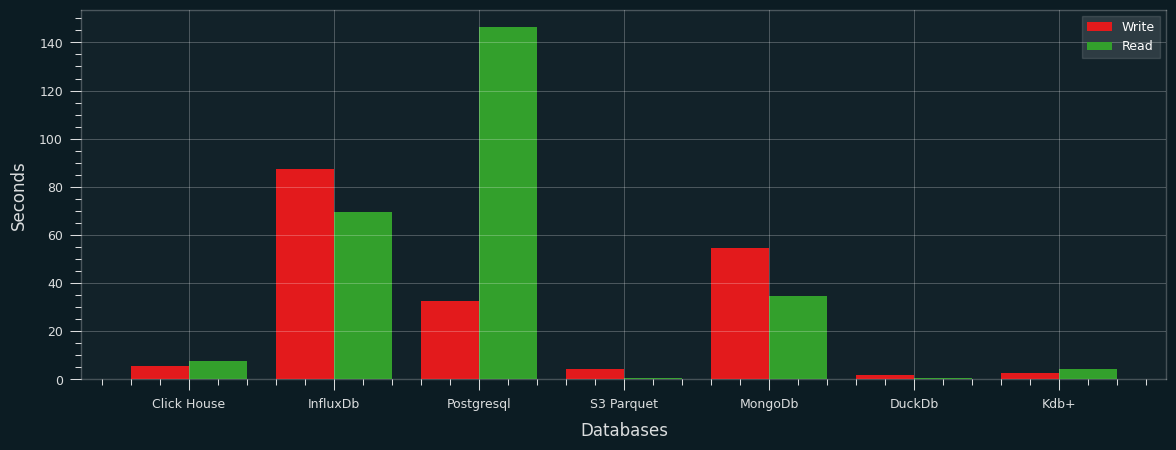

In [199]:
def plot(dark):
    mpl_style(dark)
    # plt.subplots(figsize=(16, 8))
    plt.figure().set_figwidth(14)
    x = np.arange(7)  # change here
    width = 0.40
    y1 = [
        cHouse_read_execution_time,
        influxdb_read_execution_time,
        psql_read_execution_time,
        s3_read_execution_time,
        mongo_read_execution_time,
        duckdb_read_execution_time,
        kdb_read_execution_time,
    ]  # change here
    y2 = [
        cHouse_write_execution_time,
        influxdb_write_execution_time,
        psql_write_execution_time,
        s3_write_execution_time,
        mongo_write_execution_time,
        duckdb_write_execution_time,
        kdb_write_execution_time,
    ]  # change here
    plt.bar(x - 0.2, y2, width)
    plt.bar(x + 0.2, y1, width)
    plt.xticks(
        x,
        [
            "Click House",
            "InfluxDb",
            "Postgresql",
            "S3 Parquet",
            "MongoDb",
            "DuckDb",
            "Kdb+",
        ],
    )
    plt.xlabel("Databases")
    plt.ylabel("Seconds")
    plt.legend(["Write", "Read"])  # ver
    plt.rcParams.update({"font.size": 18})
    plt.show()


plot(dark=True)

## Graph (bests)

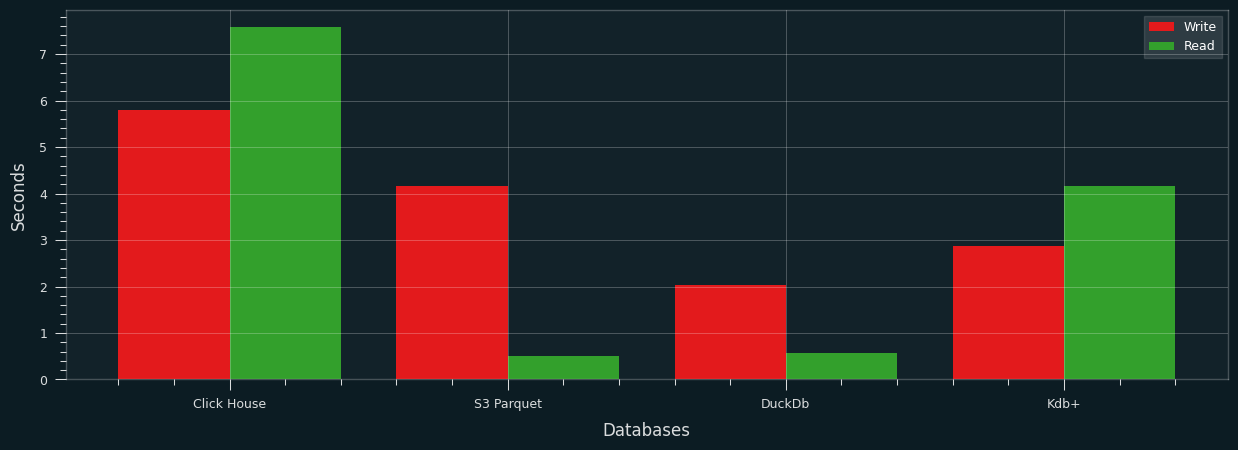

In [200]:
def plot(dark):
    mpl_style(dark)
    plt.figure().set_figwidth(15, 10)
    x = np.arange(4)  # change here
    width = 0.40
    y1 = [
        cHouse_read_execution_time,
        s3_read_execution_time,
        duckdb_read_execution_time,
        kdb_read_execution_time,
    ]  # change here
    y2 = [
        cHouse_write_execution_time,
        s3_write_execution_time,
        duckdb_write_execution_time,
        kdb_write_execution_time,
    ]  # change here
    plt.bar(x - 0.2, y2, width)
    plt.bar(x + 0.2, y1, width)
    plt.xticks(
        x,
        [
            "Click House",
            "S3 Parquet",
            "DuckDb",
            "Kdb+",
        ],
    )
    plt.xlabel("Databases")
    plt.ylabel("Seconds")
    plt.legend(["Write", "Read"])  # ver
    plt.rcParams.update({"font.size": 8})
    plt.style.use("dark_background")
    plt.show()


plot(dark=True)